# HPGe simulation: 63-TUMC30NBIO

In [8]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.signal import peak_widths
import os
import openmc_tools

In [9]:
eu152_energy_peaks_ev = np.array([121781.7, 125690, 148010, 212568, 244697.4, 251633, 271131, 275449, 285980, 295938.7, 315174, 324830, 329425, 340400,
                           344278.5, 351660, 367789.1, 411116.5, 416048, 440860, 443965, 482310, 488679.2, 493508, 503474, 511000, 520227, 523130,
                           526881, 534245, 556560, 562930, 563990, 566442, 586265, 656489, 664780, 671155, 674675, 674677, 678623, 686610, 688670,
                           712843, 719349, 727990, 764900, 768944, 778904.5, 794810, 810451, 839360, 841574, 867380, 896580, 901181, 906010, 919337,
                           926317, 930580, 958630, 963390, 964079, 974090, 990190, 1005272, 1084000, 1085337, 1089737, 1109174, 1112076, 1170930,
                           1206110, 1212948, 1249938, 1261343, 1292778, 1299142, 1348100, 1363770, 1408013, 1457643, 1528103])

eu152_decay_intensities = np.array([28.41, 0.019, 0.035, 0.0196, 7.55, 0.0671, 0.078, 0.0323, 0.01, 0.442, 0.0496, 0.0738, 0.129, 0.031, 26.59,
                                        0.014, 0.862, 2.238, 0.109, 0.0133, 0.32, 2.8, 0.0279, 0.4139, 0.0278, 0.1533, 0.054, 0.0536, 0.0113, 0.0129, 
                                        0.0368, 0.0177, 0.038, 0.457, 0.131, 0.462,  0.1437, 0.01, 0.0194, 0.17, 0.0171, 0.47, 0.02, 0.841, 0.0961,
                                        0.268, 0.0106, 0.19, 0.088, 12.97, 0.0263, 0.317, 0.016, 4.243, 0.0669, 0.084, 0.016, 0.429, 0.273, 0.0729,
                                        0.021, 0.1341, 14.5, 0.0138, 0.0315, 0.665, 0.244, 10.13, 1.73, 0.186, 13.41, 0.0365, 0.0135, 1.416, 0.186,
                                        0.0336, 0.104, 1.633, 0.0175, 0.0256, 20.85, 0.498, 0.281])


co60_energy_peaks_ev = np.array([347140, 826100, 1173222.8, 1332492, 2158570, 2505692])
co60_decay_intensities = np.array([0.0075, 0.0076, 99.85, 99.9826, 0.0012, 0.000002])

am241_energy_peaks_ev = np.array([26344.6, 32183, 33196.3, 43420, 55560, 59540.9, 98970, 102980])
am241_decay_intensities = np.array([2.31, 0.0174, 0.1215, 0.0669, 0.0181, 35.92, 0.0203, 0.0195])

cs137_energy_peaks_ev = np.array([283500, 661657])
cs137_decay_intensities = np.array([0.00058, 85.1])

na22_energy_peaks_ev = np.array([1274537])
na22_decay_intensities = np.array([99.940])

mn54_energy_peaks_ev = np.array([834848])
mn54_decay_intensities = np.array([99.9760])

ba133_energy_peaks_ev = np.array([53162.2, 79614.2, 80997.9, 160612.0, 223236.8, 276398.9, 302850.8, 356012.9, 383848.5])
ba133_decay_intensities = np.array([2.14, 2.65, 32.9, 0.638, 0.453, 7.16, 18.34, 62.05, 8.94])

co57_energy_peaks_ev = np.array([14412.9, 122060.5, 136473.56, 230400, 339690, 352330, 366800, 570090, 692410, 706540])
co57_decay_intensities = np.array([9.16, 85.6, 10.68, 0.0004, 0.0037, 0.003, 0.0012, 0.0158, 0.149, 0.005])

eu152_decay_probabilities = openmc_tools.find_decay_probabilities(eu152_decay_intensities)
co60_decay_probabilities = openmc_tools.find_decay_probabilities(co60_decay_intensities)
am241_decay_probabilities = openmc_tools.find_decay_probabilities(am241_decay_intensities)
cs137_decay_probabilities = openmc_tools.find_decay_probabilities(cs137_decay_intensities)
na22_decay_probabilities = openmc_tools.find_decay_probabilities(na22_decay_intensities)
mn54_decay_probabilities = openmc_tools.find_decay_probabilities(mn54_decay_intensities)
ba133_decay_probabilities = openmc_tools.find_decay_probabilities(ba133_decay_intensities)
co57_decay_probabilities = openmc_tools.find_decay_probabilities(co57_decay_intensities)

In [10]:
time_since_calibration = 1014 * 86400 #seconds, accurate to nearest day

co60_initial_activity = 43000 #kBq
am241_initial_activity = 41400 #kBq
cs137_initial_activity = 40200 #kBq
na22_initial_activity = 39100 #kBq
mn54_initial_activity = 42500 #kBq
ba133_initial_activity = 43200 #kBq
co57_initial_activity = 42600 #kBq

co60_half_life = 5.271 * 365 * 24 * 60 * 60
am241_half_life = 432.6 * 365 * 24 * 60 * 60 #s, half life taken from nndc
cs137_half_life = 30.007 * 365 * 24 * 60 * 60
na22_half_life = 2.60 * 365 * 24 * 60 * 60
mn54_half_life = 312.1 * 24 * 60 * 60
ba133_half_life = 10.536 * 365 * 24 * 60 * 60
co57_half_life = 271.8 * 24 * 60 * 60

co60_activity = openmc_tools.find_current_activity(co60_initial_activity, time_since_calibration, co60_half_life)
am241_activity = openmc_tools.find_current_activity(am241_initial_activity, time_since_calibration, am241_half_life)
cs137_activity = openmc_tools.find_current_activity(cs137_initial_activity, time_since_calibration, cs137_half_life)
na22_activity = openmc_tools.find_current_activity(na22_initial_activity, time_since_calibration, na22_half_life)
mn54_activity = openmc_tools.find_current_activity(mn54_initial_activity, time_since_calibration, mn54_half_life)
ba133_activity = openmc_tools.find_current_activity(ba133_initial_activity, time_since_calibration, ba133_half_life)
co57_activity = openmc_tools.find_current_activity(co57_initial_activity, time_since_calibration, co57_half_life)

## Defining the materials

In [11]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

boron_mat = openmc.Material()
boron_mat.add_element('B', 1, percent_type = 'ao')
boron_mat.set_density('g/cm3', 2.37)

carbon_mat = openmc.Material()
carbon_mat.add_element('C', 1, percent_type = 'ao')
carbon_mat.set_density('g/cm3', 2)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

lithium_mat = openmc.Material()
lithium_mat.add_element('Li', 1, percent_type = 'ao')
lithium_mat.set_density('g/cm3', 0.534)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

vacuum_mat = openmc.Material()#setting a vacuum material as air with a near-zero density
vacuum_mat.add_element('C', 0.00015, percent_type = 'ao')
vacuum_mat.add_element('N', 0.784429, percent_type = 'ao')
vacuum_mat.add_element('O', 0.210750, percent_type = 'ao')
vacuum_mat.add_element('Ar', 0.004671, percent_type = 'ao')
vacuum_mat.set_density('g/cm3', 0.001)


materials = openmc.Materials([aluminium_mat, boron_mat, carbon_mat, copper_mat, germanium_mat, lead_mat, lithium_mat, mylar_mat, vacuum_mat])
materials.export_to_xml()

# Defining the geometries

In [12]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z', boundary_type = 'vacuum')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -23], 22.84, 5, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -23], 22.84, 4.9, axis = 'z')

outer_cylinder_roof = openmc.model.RightCircularCylinder([0, 0, -0.16], 0.16, 5, axis = 'z')

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11.06], 10.494, 4.5, axis = 'z')
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.76], 10.194, 4.42, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.566], 0.003, 4.5, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.563], 0.003, 4.5, axis = 'z')

outer_dead_layer = openmc.model.RightCircularCylinder([0, 0, -6.626], 6.06, 2.85503, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -6.626], 6.06, 2.855, axis = 'z')
germanium_crystal_top = openmc.ZPlane(z0 = -0.566, boundary_type = 'transmission')
#germanium_crystal_top.id = 1

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -23), 21.104, 0.48, axis = 'z')
inner_dead_layer_cylinder = openmc.model.RightCircularCylinder([0, 0, -6.626], 4.73, 0.487, axis = 'z')
interior_hole_sphere = openmc.Sphere(0, 0, -1.896, 0.48)
inner_dead_layer_sphere = openmc.Sphere(0, 0, -1.896, 0.487)

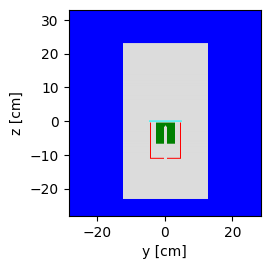

In [13]:
colour_assignment = {aluminium_mat: 'red', boron_mat: 'orange', carbon_mat: 'cyan', copper_mat: 'cyan', lead_mat: 'blue', lithium_mat: 'yellow',
                     germanium_mat: 'green', mylar_mat: 'purple', vacuum_mat: 'gainsboro'}
material_labels = {aluminium_mat: "Aluminium", boron_mat: "Boron", carbon_mat: "Carbon", copper_mat: "Copper", lithium_mat: "Lithium",
                   lead_mat: "Lead", germanium_mat: "Germanium", mylar_mat: "Mylar", vacuum_mat: "Vacuum"}

rounded_hole_region = -interior_hole_cylinder | -interior_hole_sphere
dead_layer_region = -inner_dead_layer_cylinder | -inner_dead_layer_sphere

lead_shield_region = -lead_shield_out & +lead_shield_in
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & ~rounded_hole_region
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

outer_cylinder_roof_region = -outer_cylinder_roof
outer_cylinder_roof_cell = openmc.Cell(region = outer_cylinder_roof_region)
outer_cylinder_roof_cell.fill = carbon_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & ~rounded_hole_region
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & ~rounded_hole_region & ~dead_layer_region
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

inner_dead_layer_region = dead_layer_region & -germanium_crystal & ~rounded_hole_region
inner_dead_layer_cell = openmc.Cell(region = inner_dead_layer_region)
inner_dead_layer_cell.fill = lithium_mat

outer_dead_layer_region = -outer_dead_layer & ~germanium_crystal_region & ~inner_dead_layer_region & ~rounded_hole_region
outer_dead_layer_cell = openmc.Cell(region = outer_dead_layer_region)
outer_dead_layer_cell.fill = boron_mat

vacuum_region = -lead_shield_in & ~outer_cylinder_region & ~outer_cylinder_roof_region & ~aluminium_case_region & ~aluminium_layer_region & ~mylar_layer_region & ~germanium_crystal_region & ~outer_dead_layer_region & ~inner_dead_layer_region
vacuum_cell = openmc.Cell(region=vacuum_region)
vacuum_cell.fill = vacuum_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, 
                            mylar_layer_cell, vacuum_cell, outer_cylinder_roof_cell, outer_dead_layer_cell, inner_dead_layer_cell])

plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment)
geometry.export_to_xml()


## Creating settings

In [14]:
num_particles = 10000
num_batches = 100
source_loc = (0, 0, 0.5)
    
eu152_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, eu152_energy_peaks_ev, eu152_decay_probabilities)
co60_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, co60_energy_peaks_ev, co60_decay_probabilities)
am241_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, am241_energy_peaks_ev, am241_decay_probabilities)
cs137_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, cs137_energy_peaks_ev, cs137_decay_probabilities)
na22_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, na22_energy_peaks_ev, na22_decay_probabilities)
mn54_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, mn54_energy_peaks_ev, mn54_decay_probabilities)
ba133_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, ba133_energy_peaks_ev, ba133_decay_probabilities)
co57_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, co57_energy_peaks_ev, co57_decay_probabilities)

energy_bins = np.linspace(co57_energy_peaks_ev[0]-10000, co60_energy_peaks_ev[-1]+10000, num = 8192)
tallies = openmc_tools.create_hpge_spectrum_tally(germanium_crystal_cell, energy_bins)

## Running initial HPGe spectra simulation

In [15]:
%%time

eu152_results = openmc_tools.openmc_sim(geometry, materials, eu152_settings, tallies)
eu152_spectrum = eu152_results["pulse_height"]

co60_results = openmc_tools.openmc_sim(geometry, materials, co60_settings, tallies)
co60_spectrum = co60_results["pulse_height"]
scaled_co60_spectrum = openmc_tools.scale_pulse_height_spectra(co60_spectrum, co60_activity, co60_initial_activity)

am241_results = openmc_tools.openmc_sim(geometry, materials, am241_settings, tallies)
am241_spectrum = am241_results["pulse_height"]
scaled_am241_spectrum = openmc_tools.scale_pulse_height_spectra(am241_spectrum, am241_activity, am241_initial_activity)

cs137_results = openmc_tools.openmc_sim(geometry, materials, cs137_settings, tallies)
cs137_spectrum = cs137_results["pulse_height"]
scaled_cs137_spectrum = openmc_tools.scale_pulse_height_spectra(cs137_spectrum, cs137_activity, cs137_initial_activity)

na22_results = openmc_tools.openmc_sim(geometry, materials, na22_settings, tallies)
na22_spectrum = na22_results["pulse_height"]
scaled_na22_spectrum = openmc_tools.scale_pulse_height_spectra(na22_spectrum, na22_activity, na22_initial_activity)

mn54_results = openmc_tools.openmc_sim(geometry, materials, mn54_settings, tallies)
mn54_spectrum = mn54_results["pulse_height"]
scaled_mn54_spectrum = openmc_tools.scale_pulse_height_spectra(mn54_spectrum, mn54_activity, mn54_initial_activity)

ba133_results = openmc_tools.openmc_sim(geometry, materials, ba133_settings, tallies)
ba133_spectrum = ba133_results["pulse_height"]
scaled_ba133_spectrum = openmc_tools.scale_pulse_height_spectra(ba133_spectrum, ba133_activity, ba133_initial_activity)

co57_results = openmc_tools.openmc_sim(geometry, materials, co57_settings, tallies)
co57_spectrum = co57_results["pulse_height"]
scaled_co57_spectrum = openmc_tools.scale_pulse_height_spectra(co57_spectrum, co57_activity, co57_initial_activity)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

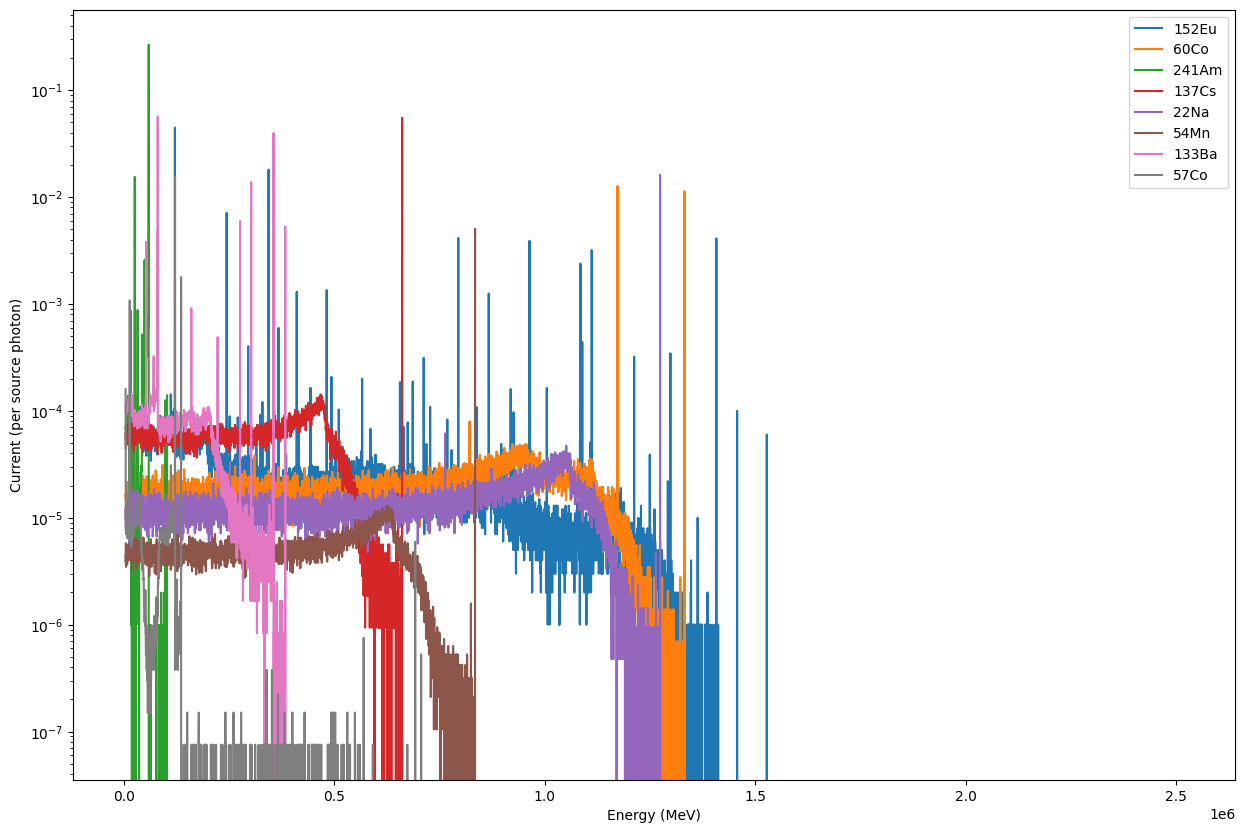

In [16]:
plt.figure(figsize = [15, 10])
results_array = [eu152_spectrum, scaled_co60_spectrum, scaled_am241_spectrum, scaled_cs137_spectrum, scaled_na22_spectrum, scaled_mn54_spectrum,
                 scaled_ba133_spectrum, scaled_co57_spectrum]
labels = ["152Eu", "60Co", "241Am", "137Cs", "22Na", "54Mn", "133Ba", "57Co"]

for i in range(len(results_array)):
    plt.plot(energy_bins[:-1], results_array[i], label = labels[i])
    
plt.yscale('log')
#plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.legend()
plt.show()

## Removing background

42
5
10
4
7
5
11
6


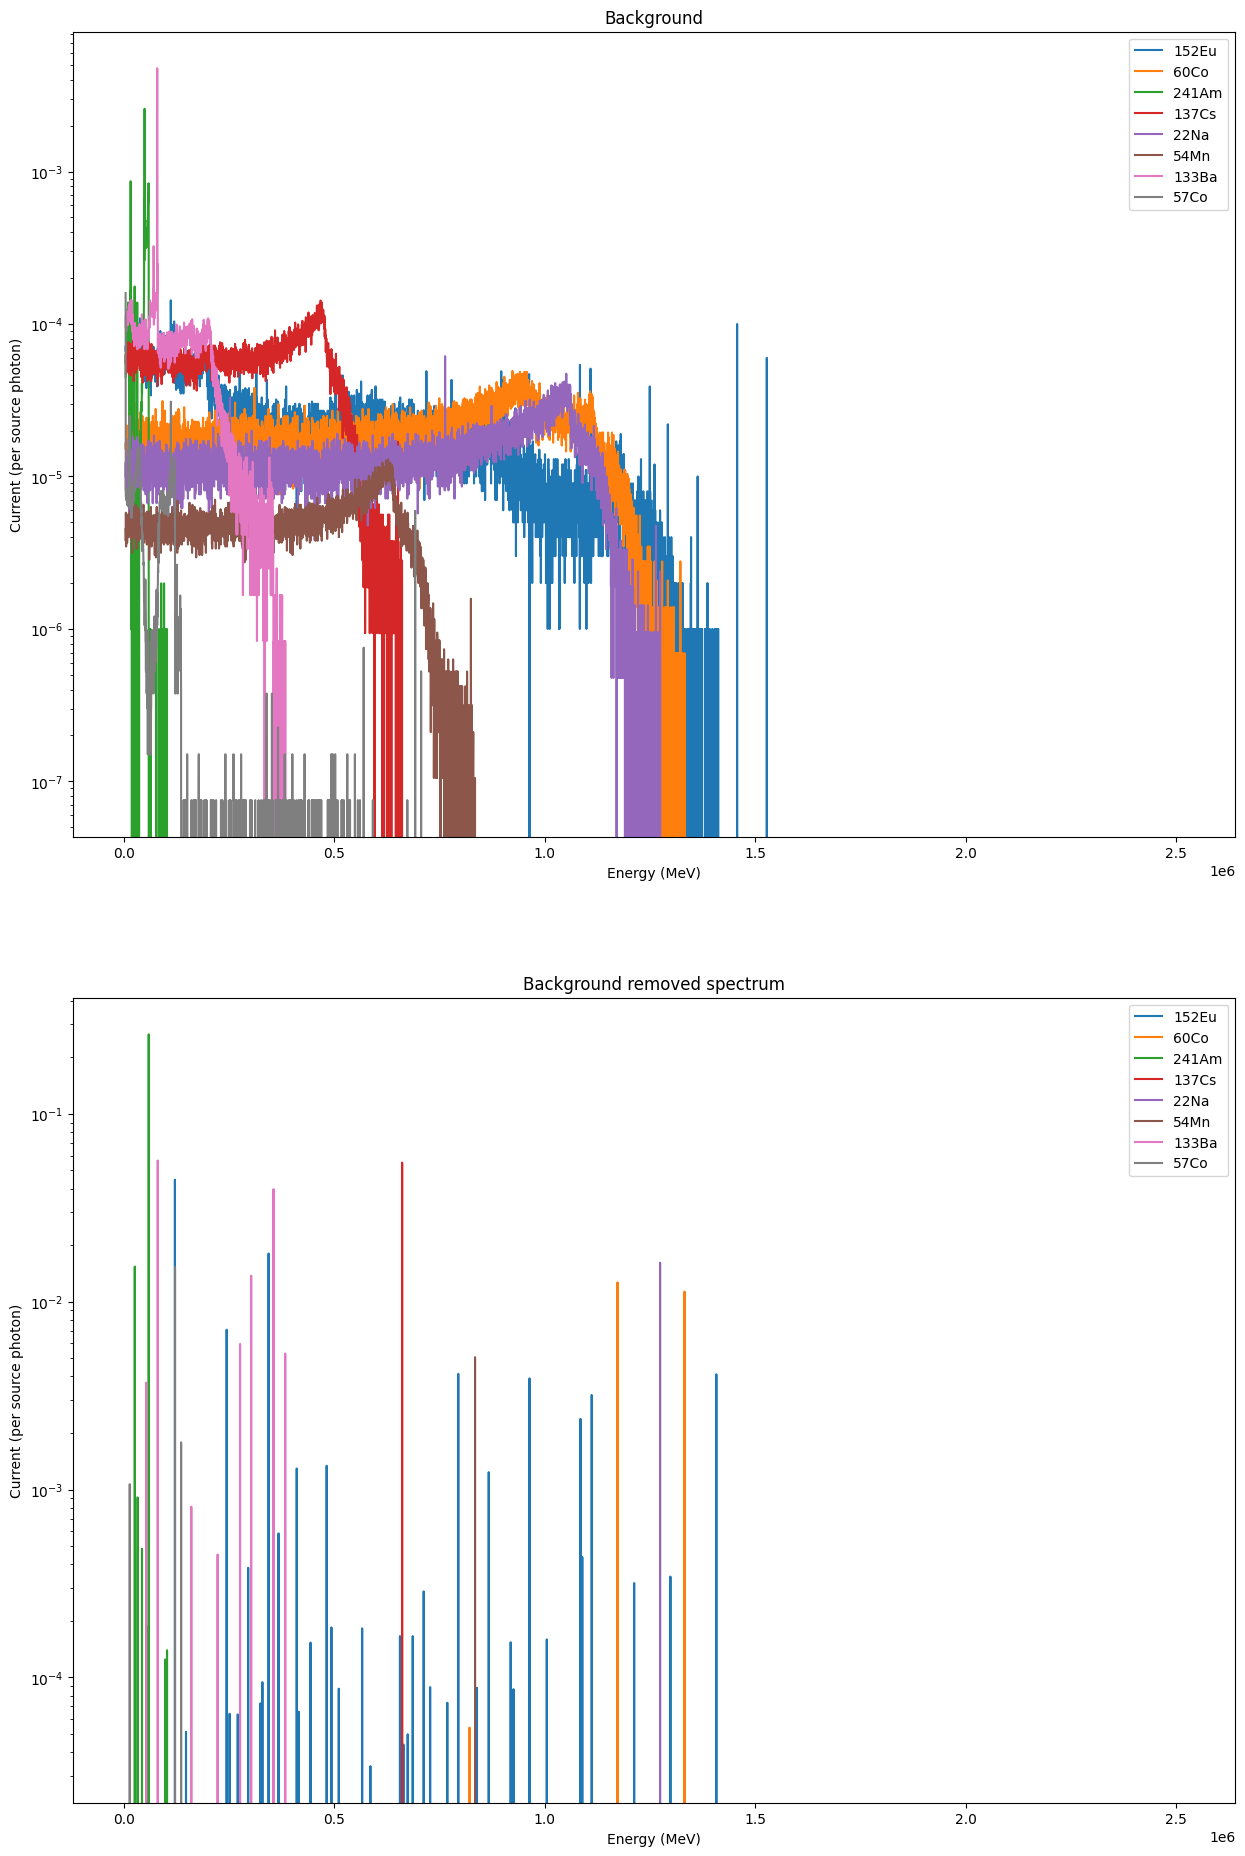

In [17]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(23)
fig.set_figwidth(15)

eu152_background = openmc_tools.find_background_spectrum(energy_bins[:-1], eu152_spectrum, eu152_energy_peaks_ev)
co60_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_co60_spectrum, co60_energy_peaks_ev)
am241_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_am241_spectrum, am241_energy_peaks_ev)
cs137_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_cs137_spectrum, cs137_energy_peaks_ev)
na22_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_na22_spectrum, na22_energy_peaks_ev)
mn54_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_mn54_spectrum, mn54_energy_peaks_ev)
ba133_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_ba133_spectrum, ba133_energy_peaks_ev)
co57_background = openmc_tools.find_background_spectrum(energy_bins[:-1], scaled_co57_spectrum, co57_energy_peaks_ev)
backgrounds_array = [eu152_background, co60_background, am241_background, cs137_background, na22_background, mn54_background, ba133_background,
                     co57_background]

eu152_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(eu152_spectrum, eu152_background)
co60_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_co60_spectrum, co60_background)
am241_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_am241_spectrum, am241_background)
cs137_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_cs137_spectrum, cs137_background)
na22_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_na22_spectrum, na22_background)
mn54_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_mn54_spectrum, mn54_background)
ba133_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_ba133_spectrum, ba133_background)
co57_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(scaled_co57_spectrum, co57_background)
background_removed_spectra_array = [eu152_background_removed_spectrum, co60_background_removed_spectrum, am241_background_removed_spectrum,
                                   cs137_background_removed_spectrum, na22_background_removed_spectrum, mn54_background_removed_spectrum,
                                    ba133_background_removed_spectrum, co57_background_removed_spectrum]

for i in range(len(labels)):
    ax[0].plot(energy_bins[:-1], backgrounds_array[i], label = labels[i])
    ax[1].plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])

    
ax[0].set_yscale('log')
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Current (per source photon)')
ax[0].set_title('Background')
ax[0].legend()

ax[1].set_yscale('log')

ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Current (per source photon)')
ax[1].set_title('Background removed spectrum')
ax[1].legend()

plt.show()

## Finding data peaks

38
3
7
1
1
1
8
3
184
3
10
1
1
1
9
3


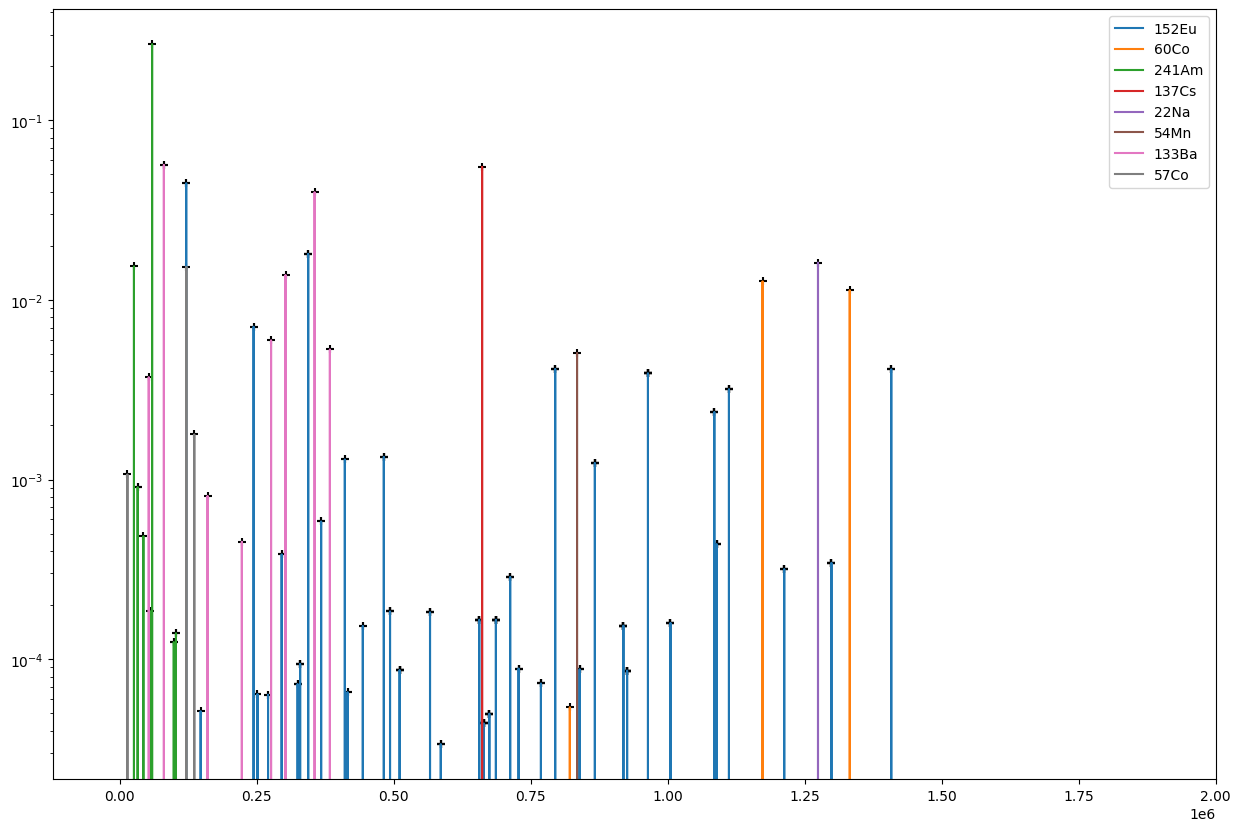

In [18]:
fig = plt.figure(figsize=[15, 10])

eu152_peaks_location, eu152_peaks = openmc_tools.find_peaks(energy_bins[:-1], eu152_background_removed_spectrum, eu152_energy_peaks_ev)
co60_peaks_location, co60_peaks = openmc_tools.find_peaks(energy_bins[:-1], co60_background_removed_spectrum, co60_energy_peaks_ev)
am241_peaks_location, am241_peaks = openmc_tools.find_peaks(energy_bins[:-1], am241_background_removed_spectrum, am241_energy_peaks_ev)
cs137_peaks_location, cs137_peaks = openmc_tools.find_peaks(energy_bins[:-1], cs137_background_removed_spectrum, cs137_energy_peaks_ev)
na22_peaks_location, na22_peaks = openmc_tools.find_peaks(energy_bins[:-1], na22_background_removed_spectrum, na22_energy_peaks_ev)
mn54_peaks_location, mn54_peaks = openmc_tools.find_peaks(energy_bins[:-1], mn54_background_removed_spectrum, mn54_energy_peaks_ev)
ba133_peaks_location, ba133_peaks = openmc_tools.find_peaks(energy_bins[:-1], ba133_background_removed_spectrum, ba133_energy_peaks_ev)
co57_peaks_location, co57_peaks = openmc_tools.find_peaks(energy_bins[:-1], co57_background_removed_spectrum, co57_energy_peaks_ev)

peak_locations_array = [eu152_peaks_location, co60_peaks_location, am241_peaks_location, cs137_peaks_location, na22_peaks_location, mn54_peaks_location,
                       ba133_peaks_location, co57_peaks_location]
peaks_array = [eu152_peaks, co60_peaks, am241_peaks, cs137_peaks, na22_peaks, mn54_peaks, ba133_peaks, co57_peaks]

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])
    plt.scatter(peak_locations_array[i], peaks_array[i], marker = '+', color = 'k')
    print(len(peaks_array[i]))

plt.yscale('log')
plt.xlim(right = 2E6)
plt.legend()
plt.show()


## Finding absolute efficiency

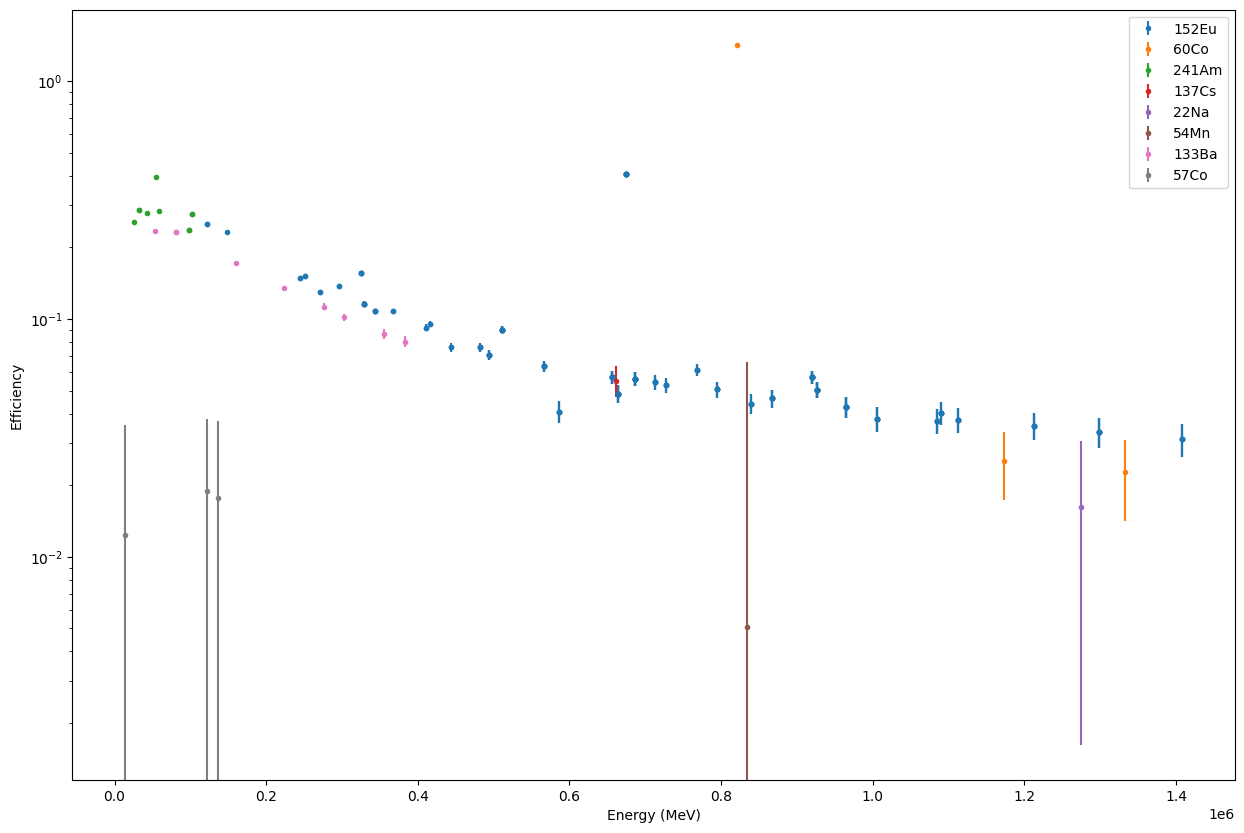

In [19]:
fig = plt.figure(figsize = [15,10])

eu152_efficiency, eu152_error = openmc_tools.find_absolute_efficiency(eu152_peaks_location, eu152_peaks, eu152_energy_peaks_ev, eu152_decay_probabilities, 1271153)
co60_efficiency, co60_error = openmc_tools.find_absolute_efficiency(co60_peaks_location, co60_peaks, co60_energy_peaks_ev, co60_decay_probabilities, 615021)
am241_efficiency, am241_error = openmc_tools.find_absolute_efficiency(am241_peaks_location, am241_peaks, am241_energy_peaks_ev, am241_decay_probabilities, 228078)
cs137_efficiency, cs137_error = openmc_tools.find_absolute_efficiency(cs137_peaks_location, cs137_peaks, cs137_energy_peaks_ev, cs137_decay_probabilities, 274722)
na22_efficiency, na22_error = openmc_tools.find_absolute_efficiency(na22_peaks_location, na22_peaks, na22_energy_peaks_ev, na22_decay_probabilities, 293926)
mn54_efficiency, mn54_error = openmc_tools.find_absolute_efficiency(mn54_peaks_location, mn54_peaks, mn54_energy_peaks_ev, mn54_decay_probabilities, 53900)
ba133_efficiency, ba133_error = openmc_tools.find_absolute_efficiency(ba133_peaks_location, ba133_peaks, ba133_energy_peaks_ev, ba133_decay_probabilities, 692961)
co57_efficiency, co57_error = openmc_tools.find_absolute_efficiency(co57_peaks_location, co57_peaks, co57_energy_peaks_ev, co57_decay_probabilities, 145097)

efficiencies_array = [eu152_efficiency, co60_efficiency, am241_efficiency, cs137_efficiency, na22_efficiency, mn54_efficiency, ba133_efficiency, 
                      co57_efficiency]
errors = [eu152_error, co60_error, am241_error, cs137_error, na22_error, mn54_error, ba133_error, co57_error]

for i in range(len(labels)):
    plt.errorbar(peak_locations_array[i], efficiencies_array[i], yerr = errors[i], fmt = '.', label = labels[i])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

## Apply Gaussian broadening

In [20]:
%%time
plt.figure(figsize = [15, 10])

eu152_fwhm = 1500
co60_fwhm = 1500
am241_fwhm = 1500
cs137_fwhm = 1500
na22_fwhm = 1500
mn54_fwhm = 1500
ba133_fwhm = 1500
co57_fwhm = 1500

broadened_eu152_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], eu152_background_removed_spectrum, eu152_fwhm)
broadened_co60_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], co60_background_removed_spectrum, co60_fwhm)
broadened_am241_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], am241_background_removed_spectrum, am241_fwhm)
broadened_cs137_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], cs137_background_removed_spectrum, cs137_fwhm)
broadened_na22_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], na22_background_removed_spectrum, na22_fwhm)
broadened_mn54_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], mn54_background_removed_spectrum, mn54_fwhm)
broadened_ba133_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], ba133_background_removed_spectrum, ba133_fwhm)
broadened_co57_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], co57_background_removed_spectrum, co57_fwhm)

broadened_spectra_array = [broadened_eu152_spectrum, broadened_co60_spectrum, broadened_am241_spectrum, broadened_cs137_spectrum,
                           broadened_na22_spectrum, broadened_mn54_spectrum, broadened_ba133_spectrum, broadened_co57_spectrum]

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], broadened_spectra_array[i], label = labels[i])

plt.yscale('log')
plt.ylim((1E-8, 1))
plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.title('Background removed spectrum')
plt.legend()
plt.show()

NameError: name 'y88_background_removed_spectrum' is not defined

<Figure size 1500x1000 with 0 Axes>